In [1]:
!pip install tld

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 6.3 MB/s eta 0:00:00


In [2]:
!pip install tqdm

In [3]:
!pip install tldextract

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 3.1 MB/s eta 0:00:00


In [4]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 7.4 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn import preprocessing
from sklearn.svm import SVC
import re
from urllib.parse import urlparse
from tld import get_tld
import os.path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import tldextract
import matplotlib.pyplot as plt
import seaborn as sns
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [6]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
colab_path = 'gdrive/My Drive/hehe/URURL/통합데이터셋/데이터셋 재분류/'

In [8]:
yong = pd.read_csv(colab_path + 'urldata0920.csv')
ka = pd.read_csv(colab_path + 'urldata.csv')

In [9]:
# 10만개
colab_path_2 = 'gdrive/My Drive/hehe/URURL/통합데이터셋/'
alexa_10k = pd.read_csv(colab_path_2 + 'cloudflare-radar-domains-top-100000-20230821-20230828.csv')

In [10]:
# Feature Engineering Refactoring
# 일괄 처리를 위한 함수화
def fd_length(parsedpath):
  try:
    tmp = parsedpath.split('/')[1]
  except:
    tmp = None
  return tmp


def feature_extract(urldata):
  def parsetest(url):
    try:
      urlparse(url if url[0:4] =='http' else "//" + url)
      return True
    except:
      return False

  tmp = urldata['url'].apply(lambda i: parsetest(i))
  urldata = urldata[tmp == True]

  #Famous Domain check

  #alexa_10k = pd.read_csv(colab_path + 'cloudflare-radar-domains-top-100000-20230821-20230828.csv')
  #alexa_10k_list = []

  #for i in alexa_10k.index.values:
  #  alexa_10k_list.append(alexa_10k['domain'][i])

  url = urldata['url'].apply(lambda i: i if i[0:4] =='http' else "//" + i)
  parsed = url.apply(lambda i: urlparse(i))
  tld = url.apply(lambda i: get_tld(i,fail_silently=True))

  urldata['scheme'] = parsed.apply(lambda i: i.scheme)
  urldata['netloc'] = parsed.apply(lambda i: i.netloc)
  urldata['params'] = parsed.apply(lambda i: i.params)
  urldata['query'] = parsed.apply(lambda i: i.query)
  urldata['fragment'] = parsed.apply(lambda i: i.fragment)
  urldata['tld'] = tld
  # Length Feature
  #Length of URL
  urldata['url_length'] = urldata['url'].apply(lambda i: len(i))

  #Hostname Length
  urldata['hostname_length'] = parsed.apply(lambda i: len(i.netloc))

  #Path Length
  urldata['path_length'] = parsed.apply(lambda i: len(i.path))

  #First Directory Length
  urldata['fd_length'] = parsed.apply(lambda i: fd_length(i.path))
  #Length of Top Level Domain
  urldata['tld_length'] = tld.apply(lambda i: len(i) if i is not None else None )

  #Count Feature
  #특수문자
  special_symbols = ['-', '@', '?', '%', '.', '=', 'http', 'https', 'www', '/', '//']
  for letter in special_symbols:
    urldata['count '+letter] = urldata['url'].apply(lambda i: i.count(letter))
  #숫자
  def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits
  urldata['count-digits']= urldata['url'].apply(lambda i: digit_count(i))
  #알파벳
  def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters
  urldata['count-letters']= urldata['url'].apply(lambda i: letter_count(i))

  # path부분의 /
  urldata['count_dir'] = parsed.apply(lambda i: i.path.count('/'))


#Use of IP or not in domain
  def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match: # 존재
        # print match.group()
        return 1
    else: # 없음
        # print 'No matching pattern found'
        return -1
  urldata['use_of_ip'] = urldata['url'].apply(lambda i: having_ip_address(i))

  #short link
  def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match: # 존재
        return 1
    else: # 없음
        return -1
  urldata['short_url'] = urldata['url'].apply(lambda i: shortening_service(i))


  #URL 속에 파일 확장자가 들어있는가?
  #파일 확장자가 들어있으면 1 , 없으면 -1
  def url_has_file(url):
    match = re.search('\.exe|\.zip|\.reg|\.rar|\.js|\.java|\.lib|\.log|\.bat|\.cmd|\.vbs|\.lnk|\.php|\.html|\.htm|\.hwp|\.hwpx|\.pptx|\.docx|\.iso|\.xls|\.xlsx',url)
    if match:
      return 1
    else:
      return -1
  urldata['url_has_file'] = urldata['url'].apply(lambda i: url_has_file(i))

  # URL 속에 Email 주소가 들어있는가?
  # 있으면 1, 없으면 -1
  def url_has_email(url):
    match = re.search('\w+\@\w+\.\w+' , url)
    if match:
      return 1
    else:
      return -1
  urldata['url_has_email'] = urldata['url'].apply(lambda i: url_has_email(i))


  #도메인과 URL의 길이 비율
  urldata['len_Domain_ratio'] = parsed.apply(lambda i: len(i.netloc)) / urldata['url_length']
  #Path와 URL의 길이 비율
  urldata['len_Path_ratio'] = parsed.apply(lambda i: len(i.path)) / urldata['url_length']
  #파라미터와 URL의 길이 비율
  urldata['len_Params_ratio'] =  parsed.apply(lambda i: len(i.params)) / urldata['url_length']
  #Query와 URL의 길이 비율
  urldata['len_Query_ratio'] =  parsed.apply(lambda i: len(i.query)) / urldata['url_length']
  #fragment와 URL의 길이 비율
  urldata['len_Fragment_ratio'] =  parsed.apply(lambda i: len(i.fragment)) / urldata['url_length']

  #의심 단어
  def suspicious_word(url):
    a = re.findall('confirm|account|secure|websc|login|signin|submit|update|logon|secure|wp|cmd|admin|ebayisapi', url)
    return len(a)
  urldata['suspicious_word'] = urldata['url'].apply(lambda i: suspicious_word(i))


  #Famous Domain check
  #alexa_10k = pd.read_csv(colab_path + 'cloudflare-radar-domains-top-100000-20230821-20230828.csv')
  alexa_10k_list = []

  for i in alexa_10k.index.values:
    alexa_10k_list.append(alexa_10k['domain'][i])

  def dom_alexa_rank(url):
   ext = tldextract.extract(url)
   domain = ext.domain + '.' + ext.suffix
   if domain in alexa_10k_list:
      return 1
   else:
      return -1
  urldata['dom_alexa_rank'] = urldata['url'].apply(lambda i: dom_alexa_rank(i))

  #check protocol
  def https(scheme):
    if scheme == 'https':
      return 1
    return -1
  urldata['use_https'] = parsed.apply(lambda i: https(i.scheme))

  def http(scheme):
    if scheme == 'http':
      return 1
    return -1
  urldata['use_http'] = parsed.apply(lambda i: http(i.scheme))

#각 URL의 엔트로피 계산
  def entropy(url):
    url = url.lower() # 알파벳 개수 세야 해서 소문자로 통일
    url_dict = {} # 알파벳 개수 중복 피해야 해서 일단 Dictionary 사용했음
    url_len = len(url) # url 길이
    p_i = pp_i = entropy = 0
  # 위 공식 참고 , pp_i는 (p_i * log2(p_i)) 를 의미함
    for i in url:
      url_dict[i] = url.count(i)
    url_dict = list(url_dict.values()) # 원할하게 하려고 리스트로 바꿨음

    for j in url_dict:
      p_i = j / url_len
      pp_i = p_i * np.log2(p_i)
      entropy += pp_i
    return -(entropy)
  urldata['entropy'] = urldata['url'].apply(lambda i: entropy(i))
  #검색량
  #def search_url_amount(url):
    #Daum_url='https://search.daum.net/search?w=tot&DA=YZR&t_nil_searchbox=btn&sug=&sugo=&sg=&o=&q='
    #strOri='&sm=tab_org&qvt=0'
    #response = requests.get(Daum_url + url +strOri)
    #getlen=len(response.text)
    #return getlen
  #urldata['search_url_amount'] = urldata['url'].apply(lambda i: search_url_amount(i))
  # 검색량 부분을 추가하니 5시간 돌려도 안끝나서 일단 주석처리
  return urldata

In [ ]:
yong = yong.drop_duplicates('url')
yong = yong.reset_index(drop=True)

In [ ]:
yong

,url,label
0,http://socialdisasterscommission.go.kr/,benign
1,http://www.bai.go.kr/mobile/index.do,benign
2,http://www.bai.go.kr,benign
3,http://www.bai.go.kr/child/index.do,benign
4,http://www.pasa.go.kr,benign
...,...,...
147894,http://222.137.33.113:43397/i,malware
147895,http://59.178.65.57:59907/i,malware
147896,http://123.129.131.17:34216/bin.sh,malware
147897,https://human-sarl.ml/ti/?1,malware


In [ ]:
ka.drop(columns = 'Unnamed: 0' , axis= 1 , inplace = True)

In [ ]:
ka.drop(columns =  'result' , axis= 1 , inplace = True)

In [ ]:
ka[ka.duplicated('url') == True]

,url,label


In [ ]:
yong = yong.sample(frac = 0.3, random_state = 42)
ka = ka.sample(frac = 0.3, random_state = 42)

In [ ]:
yong = feature_extract(yong)
ka = feature_extract(ka)

In [ ]:
yong = yong.replace(np.nan,0)

In [ ]:
target_col = 'label'
y = yong[[target_col]]
X = yong[['url_length', 'hostname_length', 'path_length',
       'tld_length', 'count -', 'count @', 'count ?', 'count %', 'count .',
       'count =', 'count http', 'count https', 'count www', 'count /',
       'count //', 'count-digits', 'count-letters', 'count_dir', 'use_of_ip',
       'short_url', 'url_has_file', 'url_has_email', 'len_Domain_ratio',
       'len_Path_ratio', 'len_Params_ratio', 'len_Query_ratio',
       'len_Fragment_ratio', 'suspicious_word', 'entropy', 'use_https',
       'use_http']]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.fit_transform(test_X)

In [ ]:
%%time

model = SVC(kernel = 'linear' , probability = True, random_state = 42 , decision_function_shape = 'ovr') # linear 커널 사용
# model = SVC(kernel = 'linear' ,prob2ability = True, random_state = 42)
result = model.fit(train_X, train_y)
print(result.score(train_X,train_y))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9233161722802307
CPU times: user 34min 14s, sys: 2.58 s, total: 34min 17s
Wall time: 34min 25s


In [ ]:
y_pred = result.predict(test_X)
accuracy = accuracy_score(test_y, y_pred)
accuracy

0.9205995041694839

[[31414   359    81   257]
 [ 1340  2002    51    84]
 [  211   124  3865    32]
 [  197     5     5  3451]]


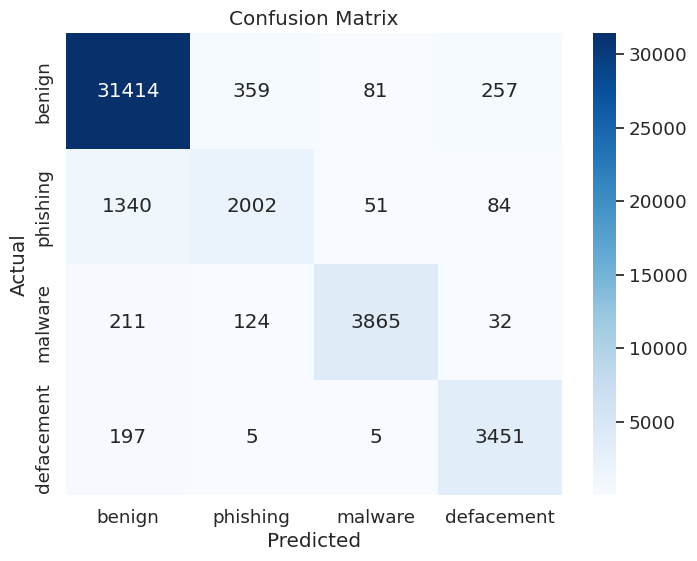

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cf = confusion_matrix(test_y, y_pred , labels = ["benign", "phishing", "malware","defacement"])
print(cf)

# Seaborn을 사용하여 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # 폰트 크기 설정

# 혼동 행렬 히트맵 생성
sns.heatmap(cf, annot=True, fmt="d", cmap="Blues", xticklabels=["benign","phishing","malware","defacement"],
            yticklabels=["benign","phishing", "malware","defacement"])

# 플롯에 제목 추가
plt.title("Confusion Matrix")

# x축 및 y축 레이블 추가
plt.xlabel("Predicted")
plt.ylabel("Actual")

# 플롯 표시
plt.show()

In [ ]:
test = pd.DataFrame({'url': ['www.naver.com','https://www.naver.com/', 'https://www.youtube.com/watch?v=cJ15o438hww', 'https://cyber.sogang.ac.kr/ilos/main/main_form.acl','https://sogang.ac.kr/index.do','google.com','https://www.hoseo.ac.kr/Home/Main.mbz', 'https://discord.com/','https://learn.hoseo.ac.kr/']})
test = feature_extract(test)
y_pred=model.predict(test[['url_length', 'hostname_length', 'path_length',
       'tld_length', 'count -', 'count @', 'count ?', 'count %', 'count .',
       'count =', 'count http', 'count https', 'count www', 'count /',
       'count //', 'count-digits', 'count-letters', 'count_dir', 'use_of_ip',
       'short_url', 'url_has_file', 'url_has_email', 'len_Domain_ratio',
       'len_Path_ratio', 'len_Params_ratio', 'len_Query_ratio',
       'len_Fragment_ratio', 'suspicious_word', 'entropy', 'use_https',
       'use_http']])
y_pred

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


array(['malware', 'malware', 'spam', 'spam', 'spam', 'malware', 'spam',
       'malware', 'malware'], dtype=object)

In [ ]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# 특정 예제에 대한 SHAP 요약 그래프 플로팅
shap.summary_plot(shap_values, X)

In [ ]:
ka = ka.replace(np.nan,0)

In [ ]:
target_col = 'label'
y = ka[[target_col]]
X = ka[['url_length', 'hostname_length', 'path_length',
       'tld_length', 'count -', 'count @', 'count ?', 'count %', 'count .',
       'count =', 'count http', 'count https', 'count www', 'count /',
       'count //', 'count-digits', 'count-letters', 'count_dir', 'use_of_ip',
       'short_url', 'url_has_file', 'url_has_email', 'len_Domain_ratio',
       'len_Path_ratio', 'len_Params_ratio', 'len_Query_ratio',
       'len_Fragment_ratio', 'suspicious_word', 'entropy', 'use_https',
       'use_http']]
ttrain_X, ttest_X, ttrain_y, ttest_y = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
ka

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
ttrain_X = scaler.fit_transform(ttrain_X)
ttest_X = scaler.fit_transform(ttest_X)

In [ ]:
%%time

model = SVC(kernel = 'linear' , probability = True, random_state = 42 , decision_function_shape = 'ovr') # linear 커널 사용
# model = SVC(kernel = 'linear' ,prob2ability = True, random_state = 42)
result = model.fit(ttrain_X, ttrain_y)
print(result.score(ttrain_X,ttrain_y))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9967853822158332
CPU times: user 2h 41min 46s, sys: 10.1 s, total: 2h 41min 56s
Wall time: 2h 42min 16s


In [ ]:
y_pred = result.predict(ttest_X)
accuracy = accuracy_score(ttest_y, y_pred)
accuracy

0.9965717162891605

[[103239    209]
 [   254  31351]]


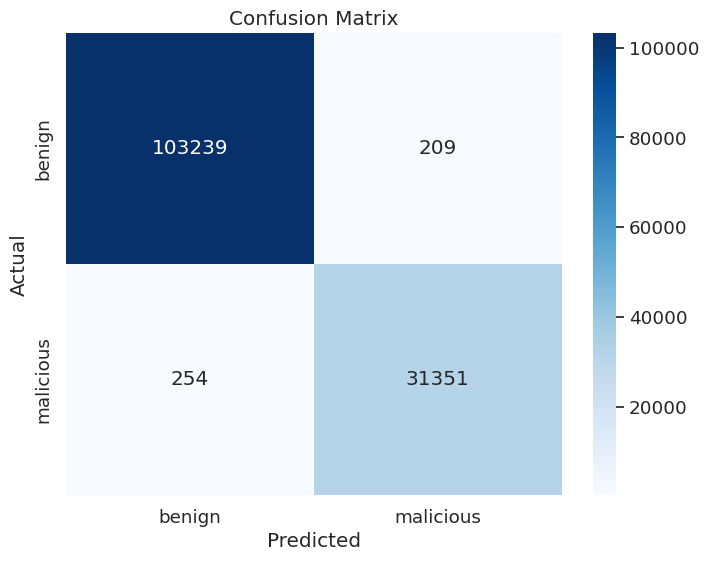

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cf = confusion_matrix(ttest_y, y_pred , labels = ["benign", "malicious"])
print(cf)

# Seaborn을 사용하여 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # 폰트 크기 설정

# 혼동 행렬 히트맵 생성
sns.heatmap(cf, annot=True, fmt="d", cmap="Blues", xticklabels=["benign","malicious"],
            yticklabels=["benign","malicious"])

# 플롯에 제목 추가
plt.title("Confusion Matrix")

# x축 및 y축 레이블 추가
plt.xlabel("Predicted")
plt.ylabel("Actual")

# 플롯 표시
plt.show()

In [ ]:
test = pd.DataFrame({'url': ['www.naver.com','https://www.naver.com/', 'https://www.youtube.com/watch?v=cJ15o438hww', 'https://cyber.sogang.ac.kr/ilos/main/main_form.acl','https://sogang.ac.kr/index.do','google.com','https://www.hoseo.ac.kr/Home/Main.mbz', 'https://discord.com/','https://learn.hoseo.ac.kr/']})
test = feature_extract(test)
y_pred=model.predict(test[['url_length', 'hostname_length', 'path_length',
       'tld_length', 'count -', 'count @', 'count ?', 'count %', 'count .',
       'count =', 'count http', 'count https', 'count www', 'count /',
       'count //', 'count-digits', 'count-letters', 'count_dir', 'use_of_ip',
       'short_url', 'url_has_file', 'url_has_email', 'len_Domain_ratio',
       'len_Path_ratio', 'len_Params_ratio', 'len_Query_ratio',
       'len_Fragment_ratio', 'suspicious_word', 'entropy', 'use_https',
       'use_http']])
y_pred

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


array(['benign', 'benign', 'benign', 'benign', 'benign', 'benign',
       'benign', 'benign', 'benign'], dtype=object)

In [ ]:
test = pd.DataFrame({'url': ['www.naver.com','https://www.naver.com/', 'https://www.youtube.com/watch?v=cJ15o438hww', 'https://cyber.sogang.ac.kr/ilos/main/main_form.acl','https://sogang.ac.kr/index.do','google.com','https://www.hoseo.ac.kr/Home/Main.mbz', 'https://discord.com/','https://learn.hoseo.ac.kr/']})
test = feature_extract(test)
y_pred=model.predict(test[['url_length', 'hostname_length', 'path_length',
       'tld_length', 'count -', 'count @', 'count ?', 'count %', 'count .',
       'count =', 'count http', 'count https', 'count www', 'count /',
       'count //', 'count-digits', 'count-letters', 'count_dir', 'use_of_ip',
       'short_url', 'url_has_file', 'url_has_email', 'len_Domain_ratio',
       'len_Path_ratio', 'len_Params_ratio', 'len_Query_ratio',
       'len_Fragment_ratio', 'suspicious_word', 'entropy', 'use_https',
       'use_http']])
y_pred

NameError: ignored

# 용범 데이터셋 (악성 부분) + urldata (정상 부분)

## 원래 학습 코드들

In [ ]:
print(len(yong[yong['label'] == 'defacement']))
print(len(yong[yong['label'] == 'phishing']))
print(len(yong[yong['label'] == 'malware']))

11914
11699
14370


In [11]:
yong_mal = yong[yong['label'] != 'benign']
yong_mal

,url,label
123362,http://help-center320.crabdance.com/verify,phishing
123363,https://bancolombia.com708792.repl.co/?fnet31,phishing
123364,https://mpnce.jkhrs.pl/sub/email@example.com,phishing
123365,https://mrtg.emailpartners.net/a/e/v0k3no?cid=...,phishing
123366,https://sds-company.su/MynVOOUnjhbhsJqN&amp;mI...,phishing
...,...,...
173904,http://222.137.33.113:43397/i,malware
173905,http://59.178.65.57:59907/i,malware
173906,http://123.129.131.17:34216/bin.sh,malware
173907,https://human-sarl.ml/ti/?1,malware


In [12]:
ka_be = ka[ka['label'] == 'benign']
ka_be.drop(columns = ['Unnamed: 0','result'],axis=1,)

,url,label
0,https://www.google.com,benign
1,https://www.youtube.com,benign
2,https://www.facebook.com,benign
3,https://www.baidu.com,benign
4,https://www.wikipedia.org,benign
...,...,...
345733,https://taekwondo.wisebytes.net/,benign
345734,https://www.steveconway.net/,benign
345735,https://www.tkd.net/,benign
345736,https://www.taekwondobible.com/,benign


In [13]:
new = pd.concat([yong_mal, ka_be], ignore_index=True)
new

,url,label,Unnamed: 0,result
0,http://help-center320.crabdance.com/verify,phishing,NaN,NaN
1,https://bancolombia.com708792.repl.co/?fnet31,phishing,NaN,NaN
2,https://mpnce.jkhrs.pl/sub/email@example.com,phishing,NaN,NaN
3,https://mrtg.emailpartners.net/a/e/v0k3no?cid=...,phishing,NaN,NaN
4,https://sds-company.su/MynVOOUnjhbhsJqN&amp;mI...,phishing,NaN,NaN
...,...,...,...,...
396280,https://taekwondo.wisebytes.net/,benign,345733.0,0.0
396281,https://www.steveconway.net/,benign,345734.0,0.0
396282,https://www.tkd.net/,benign,345735.0,0.0
396283,https://www.taekwondobible.com/,benign,345736.0,0.0


In [17]:
new[new.duplicated('url') == True]
new.drop_duplicates('url', inplace = True)

In [18]:
new = new.replace(np.nan,0)

In [19]:
target_col = 'label'
y = new[[target_col]]
X = new[['url_length', 'hostname_length', 'path_length',
       'tld_length', 'count -', 'count @', 'count ?', 'count %', 'count .',
       'count =', 'count http', 'count https', 'count www', 'count /',
       'count //', 'count-digits', 'count-letters', 'count_dir', 'use_of_ip',
       'short_url', 'url_has_file', 'url_has_email', 'len_Domain_ratio',
       'len_Path_ratio', 'len_Params_ratio', 'len_Query_ratio',
       'len_Fragment_ratio', 'suspicious_word', 'entropy', 'use_https',
       'use_http']]
ttrain_X, ttest_X, ttrain_y, ttest_y = train_test_split(X, y, test_size=0.3, random_state=42)

KeyError: ignored

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
ttrain_X = scaler.fit_transform(ttrain_X)
ttest_X = scaler.fit_transform(ttest_X)

In [ ]:
%%time

model = SVC(kernel = 'linear' , probability = True, random_state = 42 , decision_function_shape = 'ovr') # linear 커널 사용
# model = SVC(kernel = 'linear' ,prob2ability = True, random_state = 42)
result = model.fit(ttrain_X, ttrain_y)
print(result.score(ttrain_X,ttrain_y))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9864666100003696
CPU times: user 4h 16min 56s, sys: 18.4 s, total: 4h 17min 14s
Wall time: 4h 18min 4s


In [ ]:
y_pred = result.predict(ttest_X)
accuracy = accuracy_score(ttest_y, y_pred)
accuracy

0.9863841749448123

[[103543    192      7      0]
 [   151   3086     89     83]
 [    12    268   4020     62]
 [     0     26      0   3473]]


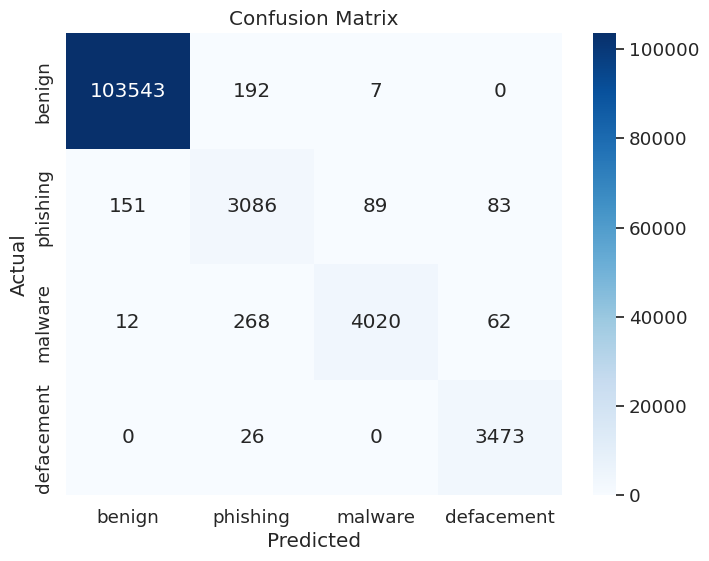

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cf = confusion_matrix(ttest_y, y_pred , labels = ["benign", "phishing","malware","defacement"])
print(cf)

# Seaborn을 사용하여 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # 폰트 크기 설정

# 혼동 행렬 히트맵 생성
sns.heatmap(cf, annot=True, fmt="d", cmap="Blues", xticklabels=["benign","phishing","malware","defacement"],
            yticklabels=["benign","phishing","malware","defacement"])

# 플롯에 제목 추가
plt.title("Confusion Matrix")

# x축 및 y축 레이블 추가
plt.xlabel("Predicted")
plt.ylabel("Actual")

# 플롯 표시
plt.show()

In [ ]:
test = pd.DataFrame({'url': ['www.naver.com','https://www.naver.com/', 'https://www.youtube.com/watch?v=cJ15o438hww', 'https://cyber.sogang.ac.kr/ilos/main/main_form.acl','https://sogang.ac.kr/index.do','google.com','https://www.hoseo.ac.kr/Home/Main.mbz', 'https://discord.com/','https://learn.hoseo.ac.kr/']})
test = feature_extract(test)
y_pred=model.predict(test[['url_length', 'hostname_length', 'path_length',
       'tld_length', 'count -', 'count @', 'count ?', 'count %', 'count .',
       'count =', 'count http', 'count https', 'count www', 'count /',
       'count //', 'count-digits', 'count-letters', 'count_dir', 'use_of_ip',
       'short_url', 'url_has_file', 'url_has_email', 'len_Domain_ratio',
       'len_Path_ratio', 'len_Params_ratio', 'len_Query_ratio',
       'len_Fragment_ratio', 'suspicious_word', 'entropy', 'use_https',
       'use_http']])
y_pred

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


array(['benign', 'benign', 'benign', 'benign', 'benign', 'benign',
       'benign', 'benign', 'malware'], dtype=object)

In [ ]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# 특정 예제에 대한 SHAP 요약 그래프 플로팅
shap.summary_plot(shap_values, X)

## 데이터셋에서 악성 부분 늘려서 해보기

In [14]:
de = pd.read_csv(colab_path + 'ISCX/' + 'iscx_defacement_good.csv')
mal = pd.read_csv(colab_path + 'URLhaus/' + 'URLhaus_good.csv')
phi = pd.read_csv(colab_path+'Phishtank/'+'Phishtank_good.csv')

In [15]:
de.drop(columns=['Unnamed: 0'],axis=1,inplace=True)
mal.drop(columns=['Unnamed: 0'],axis=1,inplace=True)
phi.drop(columns=['Unnamed: 0'],axis=1,inplace=True)

In [16]:
de = de.sample(frac = 0.7, replace = True)
phi = phi.sample(frac = 0.7, replace = True)

In [17]:
neww = new

neww = pd.concat([new,de,mal,phi], ignore_index=True)

In [18]:
neww[neww.duplicated('url') == True]
neww.drop_duplicates('url',inplace = True)

In [19]:
print(len(neww[neww['label'] == 'benign']))
print(len(neww[neww['label'] == 'defacement']))
print(len(neww[neww['label'] == 'phishing']))
print(len(neww[neww['label'] == 'malware']))

345737
53889
52812
57478


In [20]:
neww.drop(columns = ['Unnamed: 0','result'],axis=1,inplace=True)

In [21]:
neww = feature_extract(neww)

In [22]:
neww = neww.replace(np.nan,0)

In [23]:
target_col = 'label'
y = neww[[target_col]]
X = neww[['url_length', 'hostname_length', 'path_length',
       'tld_length', 'count -', 'count @', 'count ?', 'count %', 'count .',
       'count =', 'count http', 'count https', 'count www', 'count /',
       'count //', 'count-digits', 'count-letters', 'count_dir', 'use_of_ip',
       'short_url', 'url_has_file', 'url_has_email', 'len_Domain_ratio',
       'len_Path_ratio', 'len_Params_ratio', 'len_Query_ratio',
       'len_Fragment_ratio', 'suspicious_word', 'entropy', 'use_https',
       'use_http']]
ttrain_X, ttest_X, ttrain_y, ttest_y = train_test_split(X, y, test_size=0.3, random_state=42)

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
ttrain_X = scaler.fit_transform(ttrain_X)
ttest_X = scaler.fit_transform(ttest_X)

In [25]:
%%time

model = SVC(kernel = 'linear' , probability = True, random_state = 42 , decision_function_shape = 'ovr') # linear 커널 사용
# model = SVC(kernel = 'linear' ,prob2ability = True, random_state = 42)
result = model.fit(ttrain_X, ttrain_y)
print(result.score(ttrain_X,ttrain_y))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.9731505292162473
CPU times: user 9h 30min 53s, sys: 26.2 s, total: 9h 31min 19s
Wall time: 9h 31min 55s


NameError: ignored

In [26]:
y_pred = result.predict(ttest_X)
accuracy = accuracy_score(ttest_y, y_pred)
accuracy

0.9336852438128547

[[103615    182      2      0]
 [   732  13568   1027    510]
 [    63   1039  10511    228]
 [     0    129     33  15895]]


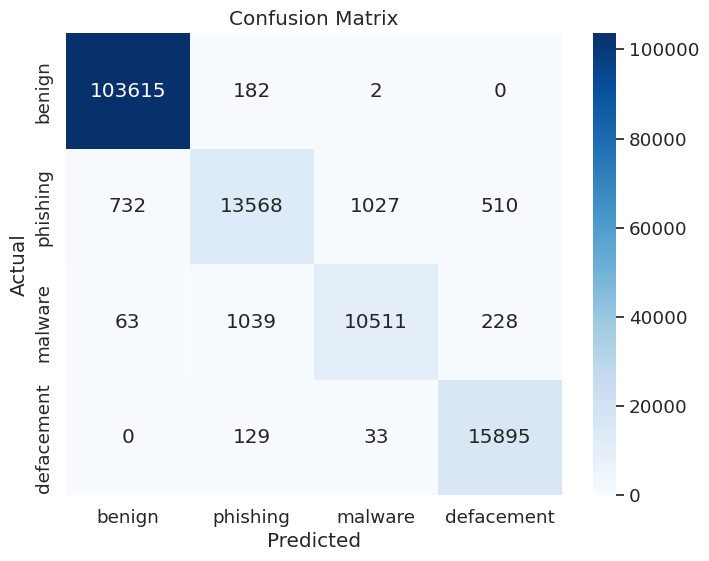

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cf = confusion_matrix(ttest_y, y_pred , labels = ["benign", "phishing","malware","defacement"])
print(cf)

# Seaborn을 사용하여 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # 폰트 크기 설정

# 혼동 행렬 히트맵 생성
sns.heatmap(cf, annot=True, fmt="d", cmap="Blues", xticklabels=["benign","phishing","malware","defacement"],
            yticklabels=["benign","phishing","malware","defacement"])

# 플롯에 제목 추가
plt.title("Confusion Matrix")

# x축 및 y축 레이블 추가
plt.xlabel("Predicted")
plt.ylabel("Actual")

# 플롯 표시
plt.show()

In [28]:
test = pd.DataFrame({'url': ['www.naver.com','https://www.naver.com/', 'https://www.youtube.com/watch?v=cJ15o438hww', 'https://cyber.sogang.ac.kr/ilos/main/main_form.acl','https://sogang.ac.kr/index.do','google.com','https://www.hoseo.ac.kr/Home/Main.mbz', 'https://discord.com/','https://learn.hoseo.ac.kr/']})
test = feature_extract(test)
y_pred=model.predict(test[['url_length', 'hostname_length', 'path_length',
       'tld_length', 'count -', 'count @', 'count ?', 'count %', 'count .',
       'count =', 'count http', 'count https', 'count www', 'count /',
       'count //', 'count-digits', 'count-letters', 'count_dir', 'use_of_ip',
       'short_url', 'url_has_file', 'url_has_email', 'len_Domain_ratio',
       'len_Path_ratio', 'len_Params_ratio', 'len_Query_ratio',
       'len_Fragment_ratio', 'suspicious_word', 'entropy', 'use_https',
       'use_http']])
y_pred

X has feature names, but SVC was fitted without feature names


array(['benign', 'benign', 'benign', 'benign', 'benign', 'benign',
       'benign', 'benign', 'benign'], dtype=object)

In [29]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# 특정 예제에 대한 SHAP 요약 그래프 플로팅
shap.summary_plot(shap_values, X)

InvalidModelError: ignored